In [2]:
# import pandas as pd
import numpy as np
import pandas as pd
# Đường dẫn đến tệp dữ liệu trên Kaggle
file_path = '/kaggle/input/vindr-mammo-dataset/breast-level_annotations.csv'

df = pd.read_csv(file_path).head(2000)
df.loc[df['breast_birads'] == 'BI-RADS 1', 'breast_birads'] = '1'
df.loc[df['breast_birads'] == 'BI-RADS 2', 'breast_birads'] = '2'
df.loc[df['breast_birads'] == 'BI-RADS 3', 'breast_birads'] = '3'
df.loc[df['breast_birads'] == 'BI-RADS 4', 'breast_birads'] = '4'
df.loc[df['breast_birads'] == 'BI-RADS 5', 'breast_birads'] = '5'

df_new = df[['image_id', 'breast_birads']].copy()
groups = df_new.groupby('breast_birads')
group_names = list(groups.groups.keys())[0:5]

#foil_df+ explained_df (rank 2)
n1 = group_names[0]
c1_df = groups.get_group(n1).head(2).reset_index(drop=True)
print(c1_df)


#corpus_df(rank 4)
n2 = group_names[2]
c3_df = groups.get_group(n2).head(2).reset_index(drop=True)
print(c3_df)

#ex
n3 = group_names[1]
c2_df=groups.get_group(n3).tail(2).reset_index(drop=True)
x2_df=groups.get_group(n3).head(2).reset_index(drop=True)
print(c2_df)
print(x2_df)
image_folder = "/kaggle/input/vindr-mammo-dataset/Processed_Images"
# from img_id find img_path
def find_images(image_id, folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file == image_id+'.png':
                image_paths=os.path.join(root, file)
    return image_paths

                           image_id breast_birads
0  dd9ce3288c0773e006a294188aadba8e             1
1  57fbdd278af5c8789a02b355c11620d4             1
                           image_id breast_birads
0  aad38467d1f04cedf300c9c8305a3536             3
1  2ccefd9e7701acf52c92275e844f7578             3
                           image_id breast_birads
0  5e65ff8020d615e6561df8aee72894ef             2
1  372aca2e23701e07dbec9ee47a8b1d86             2
                           image_id breast_birads
0  d8125545210c08e1b1793a5af6458ee2             2
1  290c658f4e75a3f83ec78a847414297c             2


In [4]:
mean = [0.6821, 0.4575, 0.2626]#[ 0.7013, -0.1607, -0.7902]#[0.485, 0.456, 0.406]
std = [0.1324, 0.1306, 0.1022]#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

import os
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.data import TensorDataset
#creat dataset return tensor+ label
class MyDataset():
    def __init__(self, df, image_dir):
        self.image_ids = df.iloc[:, 0]  
        self.labels = df.iloc[:, 1]     
        self.image_dir = image_dir
        self.downsample_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),

            ])
       
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_id=self.image_ids.iloc[index]
        image_path=find_images(image_id,self.image_dir)
        image = Image.open(image_path)
        do = self.downsample_transform(image)
        img = torch.cat([do, do, do], dim=0)
        label = self.labels.iloc[index]
        return img,label

In [5]:
c1_dataset=MyDataset(c1_df,image_folder)
c2_dataset=MyDataset(c2_df,image_folder)
c3_dataset=MyDataset(c3_df,image_folder)
x2_dataset=MyDataset(x2_df,image_folder)

c1_dataloader=DataLoader(c1_dataset, batch_size=1, shuffle=False)
c2_dataloader=DataLoader(c2_dataset, batch_size=1, shuffle=False)
c3_dataloader=DataLoader(c3_dataset, batch_size=1, shuffle=False)
x2_dataloader=DataLoader(x2_dataset, batch_size=1, shuffle=False)

In [6]:
for x,y in c1_dataloader:
    print(x.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [7]:
pip install vit-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from torchvision.models import resnet50, resnet152, densenet121
from vit_pytorch import ViT
import timm
import torch

def load_model(model_type, checkpoint_path):
    if model_type == 'resnet50':
        model = resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 512)
    elif model_type == 'resnet152':
        model = resnet152(pretrained=False)
    elif model_type == 'densenet121':
        model = densenet121(pretrained=True)
        num_classes = 512
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif model_type == 'vit':
        model_name = 'vit_base_patch16_224'  # Specify the model name
        num_classes = 512  # Number of output classes (adjust as needed)
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

    else:
        raise ValueError(f"Loại mô hình '{model_type}' không được hỗ trợ.")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Extract the model state dictionary from the checkpoint
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint  # Assuming the entire checkpoint is the state_dict
    
    # Adjust state dictionary keys if necessary
    new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model
checkp='/kaggle/input/ver1-checkpoint/version 1/weights_setting3/vit_base_patch16_224BasedModel/best.pt'
encoder=load_model('vit',checkp)

In [10]:
encoder.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5248 sha256=248934d75ffdc0c8b8543570ec27a3cd6dd043e39c2bb49be960f78ffe279720
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install grad-cam==1.4.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.0 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37003 sha256=566eed7b1925542a13fc1d22f0ebf692eb60be04d0cd629a99909087e8a494e0
  Stored in directory: /root/.cache/pip/wheels/15/d0/f2/73ee97dafcac002d6578f20b89af56a044c58dc5249be32533
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [29]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from captum.attr import IntegratedGradients, LimeBase
from captum.attr import GradientShap, KernelShap, FeatureAblation, FeaturePermutation,ShapleyValueSampling
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
x,y=next(iter(c1_dataloader))

rgb_path = find_images(c1_df.iloc[0, 0], image_folder)
img=Image.open(rgb_path)
img=img.resize((224, 224))
image_np = np.array(img) / 255.0
#matrix = np.stack((image_np,) * 3, axis=-1)
matrix = np.expand_dims(image_np, axis=2)
matrix = np.repeat(matrix, repeats=3, axis=2)
print(matrix.shape)

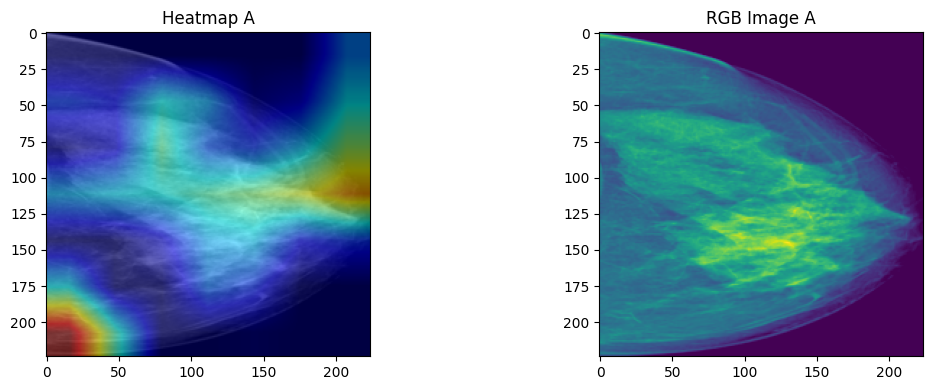

In [74]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import matplotlib.pyplot as plt


model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


targets = [ClassifierOutputTarget(281)]
grayscale_cam = cam(input_tensor=x, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(matrix, grayscale_cam, use_rgb=True)
# Display the image



fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Display the first image (heatmap A)
axes[0].imshow(visualization)
axes[0].set_title('Heatmap A')

# Display the second image (RGB image A)
axes[1].imshow(img)
axes[1].set_title('RGB Image A')

# Hiển thị các label
plt.tight_layout()
plt.show()

In [50]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

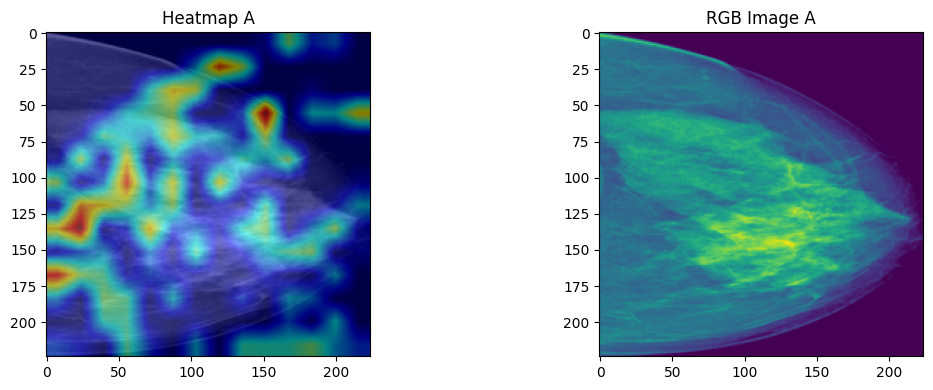

In [75]:

#model = resnet50(pretrained=True)
model=encoder
target_layers = [model.blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)

targets = None
grayscale_cam = cam(input_tensor=x, targets=targets)
matrix = np.expand_dims(image_np, axis=2)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(matrix, grayscale_cam, use_rgb=True)
# Display the image

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Display the first image (heatmap A)
axes[0].imshow(visualization)
axes[0].set_title('Heatmap A')

# Display the second image (RGB image A)
axes[1].imshow(img)
axes[1].set_title('RGB Image A')

# Hiển thị các label
plt.tight_layout()
plt.show()